# Kinetic Monte Carlo 🎲

## Introduction

Deterministic models, which rely on differential balances for polymer distributions and molecular species, are foundational in polymer reaction engineering. However, deterministic methods can become impractical or even unfeasible in certain situations. For example, they are typically limited to systems that can be described using one internal coordinate (e.g., chain length) because solving multidimensional population balances is mathematically difficult. Another significant challenge arises in systems undergoing gelation, where the moments of the chain length distribution diverge at the gel point, making it impossible to simulate the polymer structure beyond this stage.

Kinetic Monte Carlo (KMC) provides an alternative approach to simulating chemical reactions based on a stochastic interpretation. While stochastic methods have their own limitations and can be computationally intensive, they scale significantly better than deterministic methods for problems involving a high number of internal coordinates. This feature makes KMC a valuable tool for describing the microstructure of complex polymers. This [review](https://doi.org/10.1002/mren.201500020) gives a great rundown of how KMC is used in polymer reaction engineering.

KMC is usually implemented using [Gillespie's stochastic simulation algorithm] (SSA), specifically the **direct method**, which consists of the following key steps:

1. **Initialize** the system state based on the initial composition, simulation volume, and other relevant parameters.  
2. **Evaluate** the rates of all possible reactions.  
3. **Select** a reaction based on its probability of occurrence and update the affected species.  
4. **Advance** time according to the calculated time step.  
5. **(Optional) Store** the intermediate system state for later analysis.  
6. **Repeat** from step 2 until the simulation reaches the predefined stopping condition.  

To illustrate this algorithm, let’s consider a classical series-parallel reaction scheme:

\begin{align*}
A + B &\xrightarrow{k_1} C \\
C + B &\xrightarrow{k_2} D \\
D + B &\xrightarrow{k_3} E
\end{align*}

Each reaction is assumed to be elementary, leading to the following reaction rate laws:

\begin{align}
r_1 &= k_1 C_A C_B \\
r_2 &= k_2 C_C C_B \\
r_3 &= k_3 C_D C_B
\end{align}

where $k_i$ denote the rate coefficients and $C_i$ the species molar concentrations.

**Step 1** 

In the first step, we define the system size, either by specifying its initial volume $V_0$ or the absolute number of molecules of a given species $X_{i0}$. Here, we suppose the system initially consists only of species $A$ and $B$ with molar concentrations $C_{A0}$ and $C_{B0}$. If we set $X_{A0}$, the system volume and the number of $B$ molecules can be determined as follows:

\begin{equation}
V_0 = \frac{X_{A0}}{C_{A0} N_A}
\end{equation}

\begin{equation}
X_{B0} = X_{A0} \frac{C_{B0}}{C_{A0}}
\end{equation}

where $N_A$ is Avogadro's number.

**Step 2**

The KMC method relies on reaction propensities $a_i$, which are related to the conventional reaction rates by:

\begin{equation}
a_i = r_i N_A V
\end{equation}

Note that while $r_i$ is usually expressed in units of $\mathrm{mol\;L^{-1}\;s^{-1}}$, $a_i$ has units of frequency. In other words, the propensity describes the absolute number of events per unit time (not moles of events per unit volume and time).  

Since the system state is defined in terms of $X_i$, it is convenient to express propensities in terms of these quantities. For the first reaction, we can express the propensity as follows:  

\begin{equation}
a_1 = k_1 \left(\frac{X_A}{N_A V}\right) \left(\frac{X_B}{N_A V}\right) N_A V = \left(\frac{k_1}{N_A V} \right) X_A X_B
\end{equation}

As we can see, the propensity expression maintains the pattern of the original rate law ($C_i \rightarrow X_i$), but with a rescaled rate coefficient. The scaling factor depends on the overall order of the reaction; for a first-order reaction, it is unity. Moreover, if the reaction involves the same reactant twice, a factor 2 must be included in the numerator. Since the other reactions also involve two different species, we have:

\begin{equation}
a_2 = \left(\frac{k_2}{N_A V} \right) X_C X_B
\end{equation}

\begin{equation}
a_3 = \left(\frac{k_3}{N_A V} \right) X_D X_B
\end{equation}

**Step 3**

In each KMC iteration, a single reaction is selected to occur. The probability that a reaction is chosen is directly proportional to its propensity. Computationally, this is achieved by creating a vector with the cumulative sum of the propensities:

\begin{equation}
A_j = \sum_{i=1}^j a_i
\end{equation}

In our case this corresponds to:

\begin{equation}
\mathbf{A} = [a_1, a_1+a_2, a_1+a_2+a_3]  
\end{equation}

We then generate a uniform random number $z_1$ in the interval $(0, 1]$ and find the first element of $\mathbf{A}$ that exceeds $z_1 \sum_i a_i$. For instance, if $a_1 < z_1 \sum_i a_i < a_1 + a_2$, then reaction 2 is selected. The procedure is illustrated below.

<img src="./kmc_reaction_selection.svg" alt="KMC-reaction-selection" height="250px">

**Step 4**

The time between successive reaction events follows an [exponential distribution]. Consequently, the elapsed time can be calculated using the following expression:

\begin{equation}
\tau = \frac{1}{\sum_i a_i} \ln{\left(\frac{1}{z_2}\right)}
\end{equation}

where $z_2$ is a uniform random number in the interval $(0, 1]$. Note that $\tau$ is inversely proportional to the _sum_ of all propensities, not just the propensity of the reaction selected in the previous step.

**Step 5**

One is often interested in the system state trajectory, not just the final state. Therefore, state snapshots are commonly saved at predefined time or conversion intervals. Storing every iteration is unnecessary and impractical due to the very large number of iterations and the associated memory requirements. 

**Step 6**

The process repeats iteratively until a predefined stopping condition is met. This condition can be based on factors such as reaching a target simulation time, achieving a specified conversion, or depleting one of the reactants. Once the simulation ends, the collected data can be analyzed to extract insights into reaction kinetics, molecular distributions, and system dynamics.

[Gillespie's stochastic simulation algorithm]: https://en.wikipedia.org/wiki/Gillespie_algorithm
[exponential distribution]: https://en.wikipedia.org/wiki/Exponential_distribution

## Numerical Solution

Let's implement the method we just described!

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Gillespie's Algorithm

For better readability, we define a dictionary mapping species names to their corresponding indices in the concentration and molecule count vectors.

In [2]:
IDX = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}

The implementation is done in `simulate_reactions` and closely follows the logic and notation presented in the Introduction section.

In [3]:
def simulate_reactions(C0: np.ndarray,
                       k: np.ndarray,
                       tend: float,
                       XA0: int = 10**4,
                       number_snapshots: int = 100
                       ) -> dict[str, np.ndarray]:
    """Simulate reaction scheme using Kinetic Monte Carlo.

    Reaction scheme:
    A + B -> C  , k[0]
    C + B -> D  , k[1]
    D + B -> E  , k[2]

    C = [C_A, C_B, C_C, C_D, C_E]

    Parameters
    ----------
    C0 : np.ndarray
        Initial concentration vector (mol/L).
    k : np.ndarray
        Rate coefficients (L/(mol·s)).
    tend : float
        End simulation time (s).
    XA0 : int
        Initial number of `A` molecules.
    number_snapshots : int
        Number of state snapshots to be stored.

    Returns
    -------
    dict[str, np.ndarray]
        Time (s), molecule counts, molar concentrations (mol/L), and
        volume (L) for each state snapshot.
    """

    # Constants
    NA = 6.022e23

    # Initialize system state
    t = 0.0
    X = XA0 / C0[IDX['A']] * C0
    X = np.rint(X).astype(np.int64)
    V = X[IDX['A']] / (C0[IDX['A']]*NA)

    # Store initial state
    state_snapshots = {'t': [t], 'X': [X.copy()], 'V': [V]}

    # Start loop
    k_mc = np.zeros_like(k)
    a = np.zeros_like(k)
    while True:

        # Rescale rate coefficients (all 2nd order)
        k_mc[:] = k/(NA*V)

        # Evaluate reaction propensities
        a[0] = k_mc[0] * X[IDX['A']] * X[IDX['B']]
        a[1] = k_mc[1] * X[IDX['C']] * X[IDX['B']]
        a[2] = k_mc[2] * X[IDX['D']] * X[IDX['B']]

        # Select reaction
        a_cumsum = np.cumsum(a)
        a_sum = a_cumsum[-1]
        rand_rxn = np.random.rand()*a_sum
        idx_selected_rxn = np.searchsorted(a_cumsum, rand_rxn)

        # Update number of molecules and volume change
        if idx_selected_rxn == 0:
            X[IDX['A']] -= 1
            X[IDX['B']] -= 1
            X[IDX['C']] += 1
            ΔV = 0.0
        elif idx_selected_rxn == 1:
            X[IDX['C']] -= 1
            X[IDX['B']] -= 1
            X[IDX['D']] += 1
            ΔV = 0.0
        elif idx_selected_rxn == 2:
            X[IDX['D']] -= 1
            X[IDX['B']] -= 1
            X[IDX['E']] += 1
            ΔV = 0.0
        else:
            raise ValueError("Invalid reaction index.")

        # Update volume
        V += ΔV

        # Elapsed time
        if a_sum > 0.0:
            rand_tau = np.random.rand()
            tau = (1/a_sum)*np.log(1/rand_tau)
        else:
            tau = tend - t
        t += tau

        #  Store state snapshot
        if (t/tend*number_snapshots - 1 > len(state_snapshots['t'])):
            state_snapshots['t'].append(t)
            state_snapshots['X'].append(X.copy())
            state_snapshots['V'].append(V)

        # Stop if end time reached
        if t >= tend:
            break

    # Convert to numpy arrays
    state_snapshots['t'] = np.array(state_snapshots['t'])
    state_snapshots['X'] = np.array(state_snapshots['X'])
    state_snapshots['V'] = np.array(state_snapshots['V'])

    # Compute molar species concentrations
    state_snapshots['C'] = \
        state_snapshots['X']/(state_snapshots['V'][:, np.newaxis]*NA)

    return state_snapshots

### Input Parameters

We make reasonable assumptions for the initial concentrations $C_0$ and rate coefficients $k$. Feel free to experiment with these values.

In [4]:
C0 = np.array([0.5, 1.065, 0.0, 0.0, 0.0])

k = np.zeros(3)
k[0] = 5e-3
k[1] = k[0]/2
k[2] = k[1]/2

### Run Simulation

Now, let's run the simulation and observe the reaction dynamics!

In [5]:
state_snapshots = simulate_reactions(C0, k, tend=4e3, XA0=1_000)

### Plots

To visualize the simulation results, we plot the concentration of each species over time.

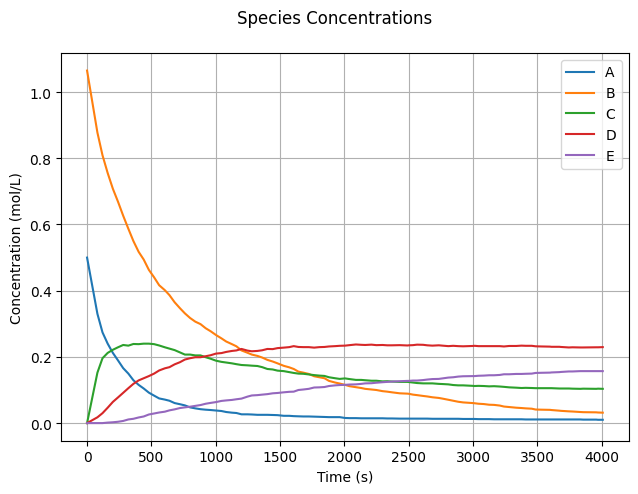

In [6]:
fig, ax = plt.subplots()
fig.suptitle("Species Concentrations")
fig.tight_layout()

for name, idx in IDX.items():
    ax.plot(state_snapshots['t'], state_snapshots['C'][:, idx], label=name)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Concentration (mol/L)")
ax.grid(True)
ax.legend()

## 🔎 Questions

1. How does the computational time scale with the initial number of molecules? Why? Is that a particular feature of this system or a general principle?
2. What is the minimum value of `XA0` required to consistently simulate a system with $C_{A0}=1$ mol/L and $C_{E0}=10^{-5}$ mol/L?
3. What are the broader implications of the requirements mentioned in question 2?
4. Derive the expression for the elapsed time $\tau$.
    * Hint: Start by understanding how to generate random samples from a given probability distribution.
5. Simulate the reaction network with a deterministic approach and compare the results.